In [2]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
import matplotlib.pyplot as plt
np. set_printoptions(threshold=np. inf)

In [3]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
date = 'Oct5th-'
filename = ''.join((date,'scan_stats.json'))
filename

'Oct5th-scan_stats.json'

In [5]:
import scan
import simulate_data
palette = simulate_data.create_palette()

In [6]:
params = {
    'M':256,
    'N':60,
    'D':71,
    'T':70000,
    'seed':1,
    'SM_repetitions':5,
    'spikes_in_SM':8,
    'noise':7000
}
M,N,D,T,seed,SM_repetitions,spikes_in_SM,noies = params.values()

In [7]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params,plot=False)

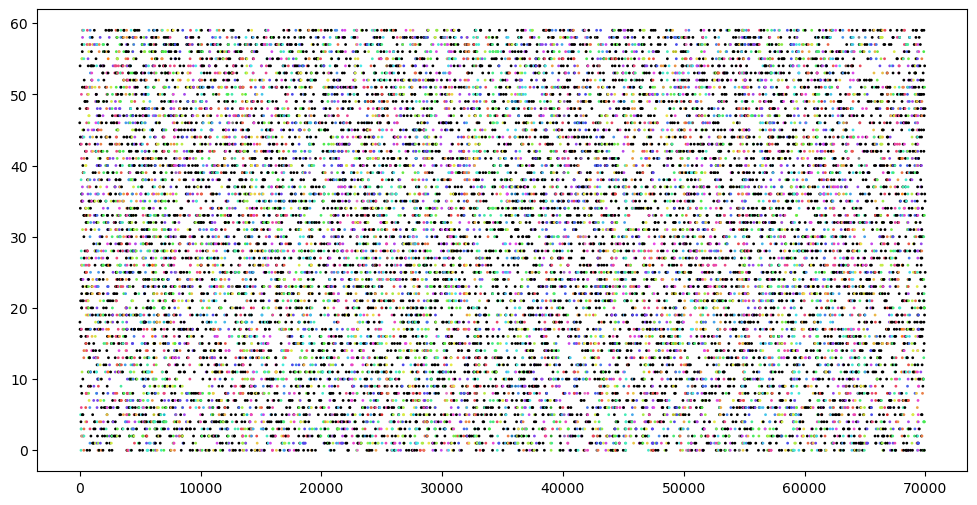

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],s=1)

In [10]:
A_sparse[0][A_sparse[2]==1]

array([ 2,  2,  2,  2,  2,  9,  9,  9,  9,  9, 27, 27, 27, 27, 27, 36, 36,
       36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49], dtype=int64)

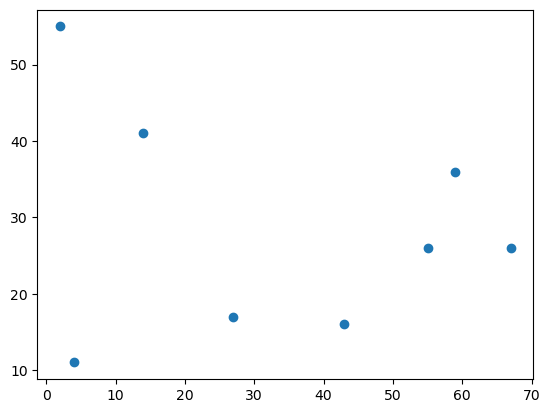

In [11]:
plt.figure()
plt.scatter(np.where(K_dense[...,1])[1],np.where(K_dense[...,1])[0])
plt.show()

# Script Version

In [12]:
import time
start = time.time()
pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster(A_sparse[1], A_sparse[0], window_dim=params['D'])
end = time.time()
SM_acc, cc, _ = simulate_data.check_ground_truth(pattern_template, K_dense)
print(SM_acc)


17215 Windows
36 patterns found...... 97% 10.01 | opt_cutoff - 1.68 | most_detections - 9etections - 9
[0.125 0.125 0.25  0.125 0.125 0.125 0.125 0.25  0.125 0.125 0.125 0.125
 0.125 1.    1.    0.125 0.125 0.125 0.25  0.125 0.125 1.    0.125 0.125
 0.125 0.125 1.    0.125 0.125 0.125 0.125 1.    0.125 0.125 0.125 0.125
 0.125 0.125 0.25  0.125 1.    1.    0.125 1.    0.125 0.125 0.125 1.
 0.125 1.    1.    0.125 0.125 0.125 0.125 0.125 0.25  0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.25  0.125 0.125 1.    0.125 0.25  0.125 0.125
 0.125 1.    0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.25  1.
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.25  1.    1.    0.125 0.125
 0.25  0.125 0.125 0.125 0.125 0.25  0.125 0.25  0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.25  0.25  0.125 0.125 1.    0.125 0.125 0.125 0.25
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 1.    0.25
 0.125 0.125 1.    0.125 0.125 0.125 0.125 0.125 0.125 1.    1.    0.125
 0.125 0.125 0.125 0.125 0.12

In [23]:
len(SM_acc[SM_acc>0.8]), len(SM_acc)

(34, 256)

# Notebook Version

## Helper functions

In [42]:
def _get_sim_mats(windows, T_labels, N_labels):
    sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        windows_n = windows[idc]
        if len(windows_n) > 1:
            x = np.zeros((len(windows_n),len(windows_n)))
            for i in range(windows_n.shape[0]):
                for j in range(windows_n.shape[0]):
                    common_rows = windows_n[i].intersection(windows_n[j])
                    num_identical_rows = len(common_rows)
                    x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
#             np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
            sim_mats[n] = x-1 
        print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")
    return sim_mats

def _cluster_windows(cutoff, N_labels, sim_mats):
    clusters = np.zeros_like(N_labels)
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        if (type(sim_mats[n]) == np.ndarray) and (not np.all(sim_mats[n] == 0)):
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(sim_mats[n], method='complete'), cutoff, criterion='distance')
    return clusters

def _check_seq(clusters, T_labels, N_labels):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_keys_filt = [list(k) for k in sublist_keys_filt]
    
    return cluster_sq, sq_counts, sublist_keys_filt

## Main code

In [43]:
T_labels, N_labels, window_dim = A_sparse[1],A_sparse[0], params['D']

In [44]:
import time
'''
T_labels an array of spiketimes
N_labels corresponding array of neuron labels
window_dim is the size of the window to cluster the spikes
'''
start = time.time()
if window_dim == None:
    window_dim = 100

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
N=max(N_labels)+1

print(f'{len(T_labels)} Windows')
windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window
    print(f'Windowing... {round(100*i/len(T_labels))}%',end='\r')


max_iter = 50
x = np.arange(0,100)
fun = lambda x,c : x**(1+c)/10**(2*c+1)
list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))

opt_cutoff = 0
max_seq_rep = 0
sim_mats = _get_sim_mats(windows, T_labels, N_labels)
end = time.time()
window_time = end-start


print("Clustering...",end="\r")

start = time.time()
for i, cutoff in enumerate(list_cutoffs): 
    clusters = _cluster_windows(cutoff, N_labels, sim_mats)
    cluster_sq, _sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

    if len(sublist_keys_filt) != 0:
        max_ = np.max([len(k) for k in sublist_keys_filt])
        if max_seq_rep < max_:
            max_seq_rep = max_
            opt_cutoff=cutoff

    print(f'progress - {100*i/max_iter}% | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

clusters = _cluster_windows(opt_cutoff, N_labels, sim_mats)
cluster_sq, sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

end = time.time()
cluster_time = end-start

''' to get the timings'''

start = time.time()
# Sort y according to x
sorted_indices = np.argsort(T_labels)
sorted_x = T_labels[sorted_indices]

print("Re-Clustering...",end="\r")

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)

    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)

end = time.time()
sequence_time = end-start

print("Extracting templates...",end="\r")

pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time in all_times[i]:
        condition = (T_labels > time-window_dim*2) & (T_labels < time + window_dim*2)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)
    print(f"Extracting templates... {round(100*i/len(all_times))}%",end="\r")

print(f"{len(pattern_template)} patterns found...")

for i,pattern in enumerate(pattern_template):
    counts = [pattern.count(k) for k in pattern]
    pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
    pattern_template[i][:,0] -= min(pattern_template[i][:,0])
    pattern_template[i] = np.unique(pattern_template[i],axis=0)

10442 Windows
0 patterns found...s...ff - 10.01 | opt_cutoff - 0 | most_detections - 0etections - 000


### Debugging...

In [55]:
A_sparse[1][A_sparse[0]==2]

array([  68,  104,  120,  148,  168,  193,  224,  249,  255,  266,  295,
        314,  329,  364,  377,  399,  408,  413,  423,  435,  443,  471,
        504,  522,  553,  568,  578,  630,  638,  652,  659,  702,  727,
        760,  766,  771,  780,  789,  805,  807,  807,  807,  808,  823,
        848,  855,  870,  877,  888,  890,  901,  937,  971,  992, 1007,
       1007, 1034, 1055, 1069, 1074, 1075, 1084, 1084, 1086, 1095, 1109,
       1137, 1140, 1144, 1166, 1173, 1192, 1200, 1227, 1244, 1293, 1301,
       1303, 1313, 1381, 1396, 1408, 1429, 1443, 1450, 1469, 1477, 1539,
       1546, 1558, 1576, 1587, 1620, 1636, 1648, 1682, 1692, 1697, 1736,
       1757, 1761, 1776, 1819, 1822, 1835, 1841, 1862, 1868, 1875, 1883,
       1914, 1918, 1934, 1941, 1992, 1993, 2031, 2035, 2041, 2058, 2063,
       2088, 2093, 2112, 2118, 2150, 2164, 2173, 2192, 2216, 2220, 2221,
       2234, 2254, 2265, 2274, 2294, 2301, 2323, 2350, 2394, 2406, 2412,
       2439, 2453, 2461, 2497, 2500, 2510, 2511, 25

In [58]:
A_sparse[2][A_sparse[0]==2]

array([140,  97, 140,   1,   3, 204, 140,   3,   0,   0,  86, 171, 183,
         1, 125,  58, 171,  98,  96, 150, 217, 178,  58,  31, 125,  96,
        31,  98,   3, 204, 171,  18,  40, 140, 134,  84,  94,  94, 212,
         5, 134, 159,  32,  33, 202,  32, 159,  58,   1,  32,   8,  32,
       134,   0,  33, 244, 171,  33, 212, 212,  18,   0, 154, 204, 125,
       120, 221, 244, 217,  31,  31,   3, 150, 120,  96, 154, 150, 221,
       178, 159, 244, 154, 212, 202,  18, 236, 244, 183,   3,   5, 183,
         0, 221,  33,  97,  97,  86,   8,  84, 204,  98, 202, 154,   5,
        31,  96, 154,   0, 217, 125, 134,  98,  86,  58, 244,  33,  84,
         1,   8,  84, 183,  97, 202, 178,   5, 217,   1,  32, 120,  86,
        32, 212,  18,  32,  40, 236, 202,  32,  40, 102, 236,  98,  18,
       236,   8, 140, 102,  86, 150,  97, 134, 159, 183, 178, 120,  58,
         8,  40,   0, 159, 217,  94, 236,   0,  84, 178,  94, 125, 221,
       171, 221, 204, 120, 150,   0,   5,   0, 102,  40,  96,  9

In [59]:
len(np.unique(A_sparse[2][A_sparse[0]==2]))

35

In [54]:
A_sparse[0][A_sparse[2]==1]

array([ 2,  2,  2,  2,  2,  9,  9,  9,  9,  9, 27, 27, 27, 27, 27, 36, 36,
       36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49], dtype=int64)

In [46]:
K_sparse[0],K_sparse[2] # These are the neurons that participate in a spiking motif

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6, 

In [47]:
windows, T_labels, N_labels
sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
for n in np.unique(N_labels):
    idc = np.where(N_labels==n)[0]
    windows_n = windows[idc]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                common_rows = windows_n[i].intersection(windows_n[j])
                num_identical_rows = len(common_rows)
                x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
#             np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
        sim_mats[n] = x-1 
    print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")


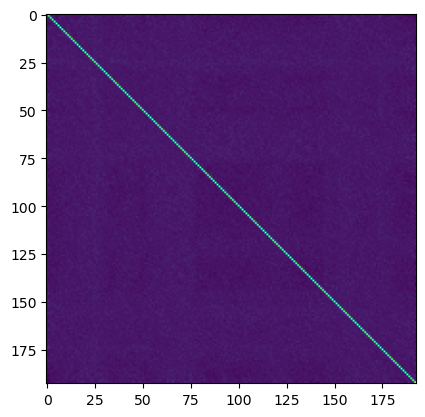

In [60]:
%matplotlib inline
plt.figure()
plt.imshow(sim_mats[1]) # This looks right because there is only 1 repeat of this pattern...

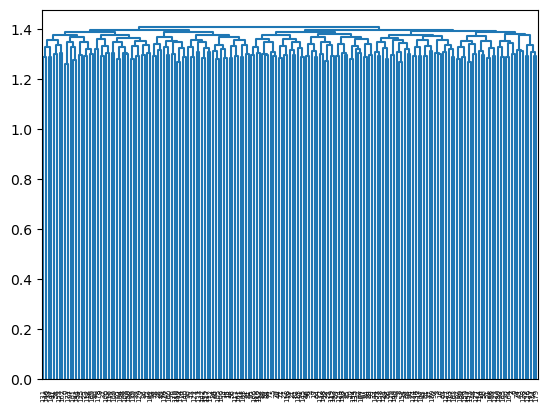

In [61]:
plt.figure()
dn = dendrogram(linkage(sim_mats[2],method='complete',optimal_ordering=False))
plt.show()